# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
# Todo add a logger
# Todo move to the latest keras

In [39]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')
args.n_splits = 5
args.n_jobs = 3

args.X = args.raw_train.iloc[:, 1:].copy()
args.y = args.raw_train['label'].copy()
args.x = args.raw_test.copy()

args.run_cnn = True

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [3]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


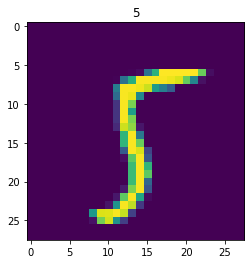

In [17]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1) 
title = args.raw_train.iloc[random_row, 0]
plt.title(title)
imgplot = plt.imshow(args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28))

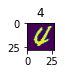

In [7]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1) 
title = args.raw_train.iloc[random_row, 0]
fig, ax = plt.subplots()
fig.set_size_inches(0.5, 0.5)
ax.set_title(title)
imgplot = ax.imshow(args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28))

## 2. Training

In [8]:
def predict(X, y, x, build_classifier, parameters, splits=args.n_splits, n_jobs=args.n_jobs):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    classifier = build_classifier()
    gcv = GridSearchCV(classifier, parameters, n_jobs=n_jobs, cv=skf, verbose=5)
    gcv.fit(X, y)
    print('Best params: ' + repr(gcv.best_params_))
    print('Best CV score: ' + repr(gcv.best_score_))
    print('Best std:' + repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    classifier = build_classifier(gcv.best_params_)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return gcv.best_params_, gcv.best_score_, predictions.astype(int)

In [9]:
def csv_predictions(predictions, filename):
    image_ids = np.arange(1, len(predictions) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    print('Saved file: ', filepath)

In [10]:
from keras import layers 
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [35]:
model.fit(args.X.to_numpy().reshape(args.X.shape[0], 28, 28, 1), pd.get_dummies(args.y, prefix='label').to_numpy(), epochs=200, batch_size=64, verbose=2)

Epoch 1/200
 - 11s - loss: 0.0173 - accuracy: 0.9984
Epoch 2/200
 - 12s - loss: 0.0288 - accuracy: 0.9982
Epoch 3/200
 - 11s - loss: 0.0132 - accuracy: 0.9987
Epoch 4/200
 - 11s - loss: 0.0183 - accuracy: 0.9987
Epoch 5/200
 - 11s - loss: 0.0163 - accuracy: 0.9989
Epoch 6/200
 - 11s - loss: 0.0146 - accuracy: 0.9986
Epoch 7/200
 - 11s - loss: 0.0161 - accuracy: 0.9988
Epoch 8/200
 - 10s - loss: 0.0248 - accuracy: 0.9982
Epoch 9/200
 - 11s - loss: 0.0148 - accuracy: 0.9988
Epoch 10/200
 - 11s - loss: 0.0172 - accuracy: 0.9988
Epoch 11/200
 - 11s - loss: 0.0147 - accuracy: 0.9989
Epoch 12/200
 - 11s - loss: 0.0141 - accuracy: 0.9988
Epoch 13/200
 - 11s - loss: 0.0174 - accuracy: 0.9989
Epoch 14/200
 - 10s - loss: 0.0201 - accuracy: 0.9983
Epoch 15/200
 - 12s - loss: 0.0140 - accuracy: 0.9990
Epoch 16/200
 - 13s - loss: 0.0185 - accuracy: 0.9988
Epoch 17/200
 - 12s - loss: 0.0182 - accuracy: 0.9989
Epoch 18/200
 - 11s - loss: 0.0247 - accuracy: 0.9987
Epoch 19/200
 - 11s - loss: 0.0253 - 

Epoch 152/200
 - 11s - loss: 0.0030 - accuracy: 0.9999
Epoch 153/200
 - 11s - loss: 0.0079 - accuracy: 0.9999
Epoch 154/200
 - 11s - loss: 0.0069 - accuracy: 0.9998
Epoch 155/200
 - 12s - loss: 0.0067 - accuracy: 0.9999
Epoch 156/200
 - 12s - loss: 0.0079 - accuracy: 0.9998
Epoch 157/200
 - 12s - loss: 0.0046 - accuracy: 0.9999
Epoch 158/200
 - 11s - loss: 0.0080 - accuracy: 0.9998
Epoch 159/200
 - 11s - loss: 0.0071 - accuracy: 0.9999
Epoch 160/200
 - 11s - loss: 0.0173 - accuracy: 0.9997
Epoch 161/200
 - 12s - loss: 0.0067 - accuracy: 0.9999
Epoch 162/200
 - 11s - loss: 0.0053 - accuracy: 0.9999
Epoch 163/200
 - 11s - loss: 0.0092 - accuracy: 0.9997
Epoch 164/200
 - 12s - loss: 0.0206 - accuracy: 0.9996
Epoch 165/200
 - 11s - loss: 0.0013 - accuracy: 1.0000
Epoch 166/200
 - 11s - loss: 0.0128 - accuracy: 0.9997
Epoch 167/200
 - 11s - loss: 0.0105 - accuracy: 0.9998
Epoch 168/200
 - 11s - loss: 0.0073 - accuracy: 0.9998
Epoch 169/200
 - 11s - loss: 0.0094 - accuracy: 0.9998
Epoch 170/

In [40]:
if args.run_cnn:
    predictions = model.predict(args.x.to_numpy().reshape(args.x.shape[0], 28, 28, 1))
    predictions = np.argmax(predictions, axis=1)
    csv_predictions(predictions, 'cnn_predictions.csv')

Saved file:  ../predictions/cnn_predictions.csv


In [ ]:
assert False

In [36]:
prediction.shape

(28000, 10)

In [28]:
args.X.shape
args.X.to_numpy().reshape(args.X.shape[0], 28, 28, 1)
pd.get_dummies(args.y, prefix='label').to_numpy()

(42000, 10)

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

def svm_classifier_builder(params_dict=None):
    _params_dict = params_dict if params_dict else {}
    return SVC(**_params_dict, kernel='linear')

parameters = {'C': [0.01], 'gamma': [0.001]}

if args.run_svm:
    best_params, score, predictions = predict(args.X, args.y, args.x, svm_classifier_builder, parameters)
    csv_predictions(predictions, 'svm_predictions.csv')

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Model  | Test score  |
|---|---|
| SVM  | 0.91900 |
| Random Forest  | 0.96814 |
| Extra Trees  | 0.97228 |
| XgBoost  | 0.96300 |
| MLP  | 0.97542 |